# Libraries

In [74]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
# import warnings
# import sys
# if not sys.warnoptions:
#     warnings.simplefilter("ignore")
np.random.seed(42)

# Dataset

## Load

In [77]:
# Load the dfset.
df = pd.read_csv("../src/data/customer_segmentation.csv", sep="\t")

# Let's see how many rows we got.
print(f"Number of individuals in the dataset: {len(df)}")

# Let's print the first 5 rows of our dataframe.
df.head()

Number of individuals in the dataset: 2240


ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

## Data cleaning

In [78]:
# Check how many missing values we have.
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [79]:
# Remove the missing values.
df = df.dropna()
print(f"The new total number of records is: {len(df)}")

The new total number of records is: 2216


## Data Processing

In [80]:
# Let's pass to datetime the column "Dt_Customer".
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
dates = []
for i in df["Dt_Customer"]:
    i = i.date()
    dates.append(i)  

# Dates of register of the newest and oldest customers.
print(f"The newest customer's was registered on: {max(dates)}")
print(f"The oldest customer's was registered on: {min(dates)}")

The newest customer's was registered on: 2014-12-06
The oldest customer's was registered on: 2012-01-08


In [81]:
# As the dfset is old, let's use the date of the newest customer as the reference date.
last_customer = max(df["Dt_Customer"])

# Create a new column with the number of days that the customer is registered.
df["Customer_For"] = last_customer - df["Dt_Customer"]

# Pass days to numeric.
df["Customer_For"] = pd.to_numeric(df["Customer_For"], errors="coerce")

In [ ]:
#Get list of categorical variables
s = (df.dtypes == 'object')
categorical_cols = list(s[s].index)

print("Categorical variables in the dataset:", categorical_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [ ]:
# Use label encoder, to transform variables to numerical.
LE=LabelEncoder()
for i in categorical_cols:
    df[i]=df[[i]].apply(LE.fit_transform)

All features are now numerical


## Feature Engineering

* Extract the **"Age"** of a customer by the **"Year_Birth"** indicating the birth year of the respective person.
* Create another feature **"Spent"** indicating the total amount spent by the customer in various categories over the span of two years.
* Create another feature **"Living_With"** out of **"Marital_Status"** to extract the living situation of couples.
* Create a feature **"Children"** to indicate total children in a household that is, kids and teenagers.
* To get further clarity of household, Creating feature indicating **"Family_Size"**
* Create a feature **"Is_Parent"** to indicate parenthood status
* Lastly, I will create three categories in the **"Education"** by simplifying its value counts.
* Dropping some of the redundant features

In [82]:
#Age of customer today 
df["Age"] = 2021-df["Year_Birth"]

#Total spendings on various items
df["Spent"] = df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] + df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]

#Deriving living situation by marital status"Alone"
df["Living_With"]= df["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone"})

#Feature indicating total children living in the household
df["Children"]= df["Kidhome"] + df["Teenhome"]

#Feature for total members in the householde
df["Family_Size"] = df["Living_With"].replace({"Alone": 1, "Partner":2}) + df["Children"]

#Feature pertaining parenthood
df["Is_Parent"] = np.where(df.Children > 0, 1, 0)

#Segmenting education levels in three groups
df["Education"]=df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
df=df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
df = df.drop(to_drop, axis=1)

# Data exploration

In [83]:
# Let's use describe on the first 10 columns of df.
df.iloc[:, :10].describe()

Income      Kidhome     Teenhome      Recency        Wines  \
count    2216.000000  2216.000000  2216.000000  2216.000000  2216.000000   
mean    52247.251354     0.441787     0.505415    49.012635   305.091606   
std     25173.076661     0.536896     0.544181    28.948352   337.327920   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35303.000000     0.000000     0.000000    24.000000    24.000000   
50%     51381.500000     0.000000     0.000000    49.000000   174.500000   
75%     68522.000000     1.000000     1.000000    74.000000   505.000000   
max    666666.000000     2.000000     2.000000    99.000000  1493.000000   

            Fruits         Meat         Fish       Sweets  
count  2216.000000  2216.000000  2216.000000  2216.000000  
mean     26.356047   166.995939    37.637635    27.028881  
std      39.793917   224.283273    54.752082    41.072046  
min       0.000000     0.000000     0.000000     0.000000  
25%       2.000000    16.000000     3.000000     1.000000  
50%       8.000000    68.000000    12.000000     8.000000  
75%      33.000000   232.250000    50.000000    33.000000  
max     199.000000  1725.000000   259.000000   262.000000

In [84]:
# The 10 columns after the first 10.
df.iloc[:, 10:20].describe()

Gold  NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
count  2216.000000        2216.000000      2216.000000          2216.000000   
mean     43.965253           2.323556         4.085289             2.671029   
std      51.815414           1.923716         2.740951             2.926734   
min       0.000000           0.000000         0.000000             0.000000   
25%       9.000000           1.000000         2.000000             0.000000   
50%      24.500000           2.000000         4.000000             2.000000   
75%      56.000000           3.000000         6.000000             4.000000   
max     321.000000          15.000000        27.000000            28.000000   

       NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
count        2216.000000        2216.000000   2216.000000   2216.000000   
mean            5.800993           5.319043      0.073556      0.074007   
std             3.250785           2.425359      0.261106      0.261842   
min             0.000000           0.000000      0.000000      0.000000   
25%             3.000000           3.000000      0.000000      0.000000   
50%             5.000000           6.000000      0.000000      0.000000   
75%             8.000000           7.000000      0.000000      0.000000   
max            13.000000          20.000000      1.000000      1.000000   

       AcceptedCmp5  AcceptedCmp1  
count   2216.000000   2216.000000  
mean       0.073105      0.064079  
std        0.260367      0.244950  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      1.000000

In [85]:
# The last 8 columns.
df.iloc[:, 20:28].describe()

AcceptedCmp2     Complain     Response  Customer_For          Age  \
count   2216.000000  2216.000000  2216.000000  2.216000e+03  2216.000000   
mean       0.013538     0.009477     0.150271  4.423735e+16    52.179603   
std        0.115588     0.096907     0.357417  2.008532e+16    11.985554   
min        0.000000     0.000000     0.000000  0.000000e+00    25.000000   
25%        0.000000     0.000000     0.000000  2.937600e+16    44.000000   
50%        0.000000     0.000000     0.000000  4.432320e+16    51.000000   
75%        0.000000     0.000000     0.000000  5.927040e+16    62.000000   
max        1.000000     1.000000     1.000000  9.184320e+16   128.000000   

             Spent     Children  
count  2216.000000  2216.000000  
mean    607.075361     0.947202  
std     602.900476     0.749062  
min       5.000000     0.000000  
25%      69.000000     0.000000  
50%     396.500000     1.000000  
75%    1048.000000     1.000000  
max    2525.000000     3.000000

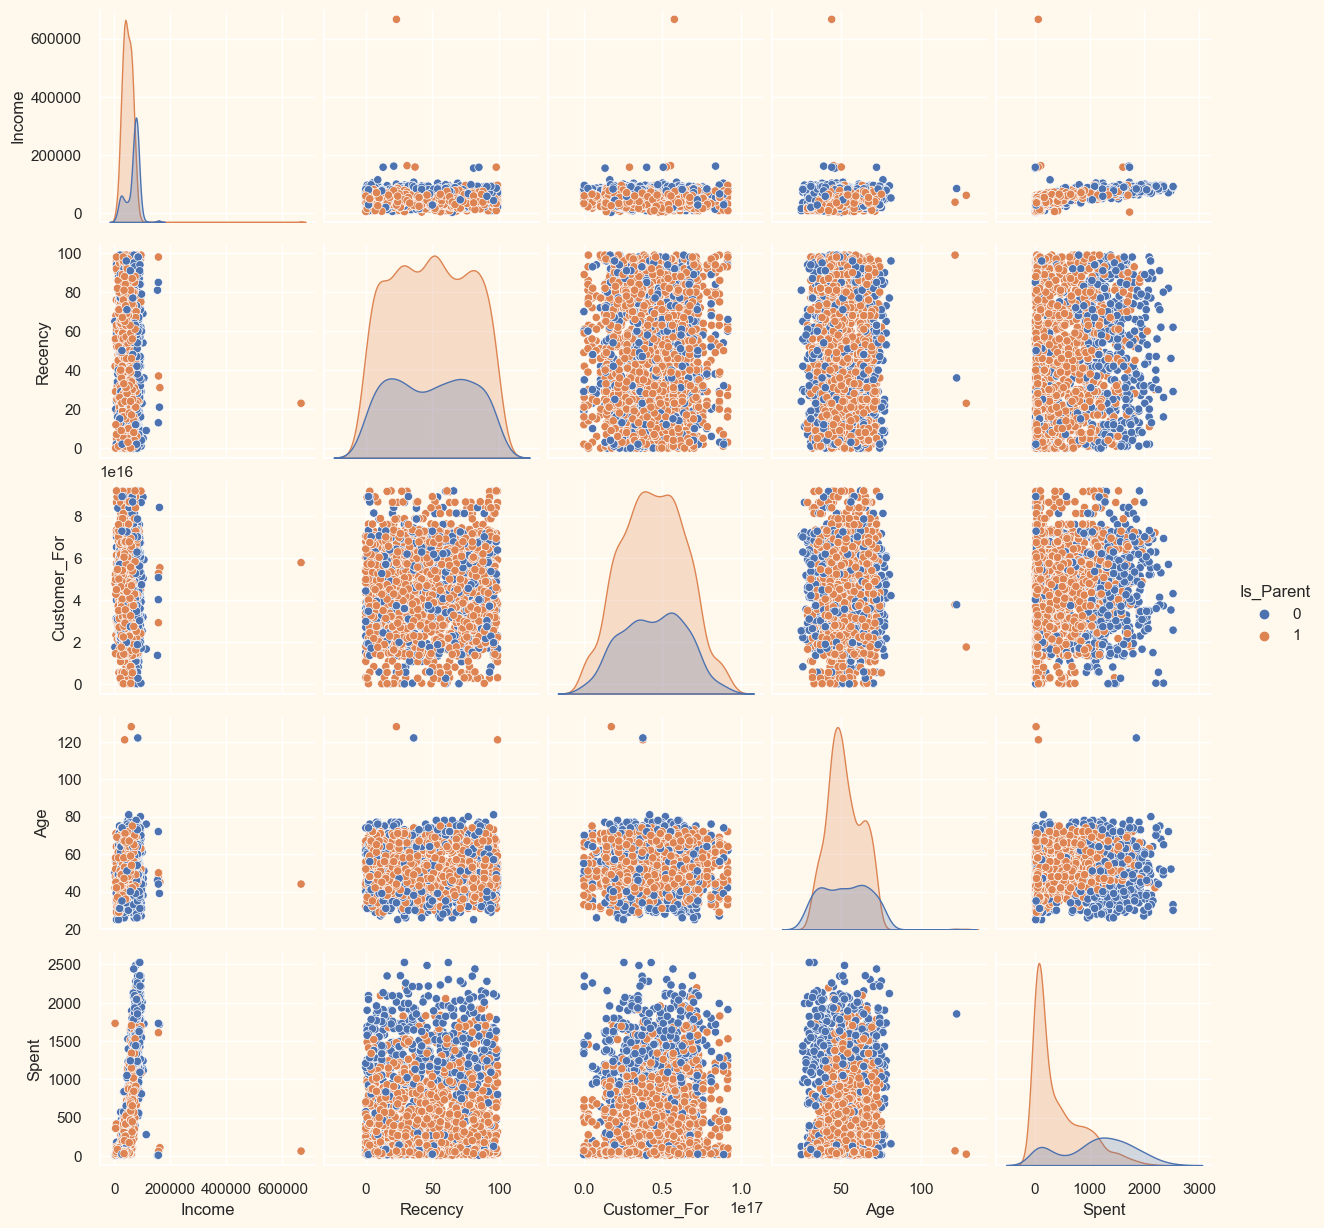

In [86]:
# Let's see the distribution of the categorical variables.
sns.pairplot(df[["Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]], hue= "Is_Parent")
plt.show()

In [111]:
# There is one person who income is more than 600.000 and three people who has more than 100 years, I will get rid of them.
df = df[df["Income"] < 600000]
df = df[df["Age"] < 100]

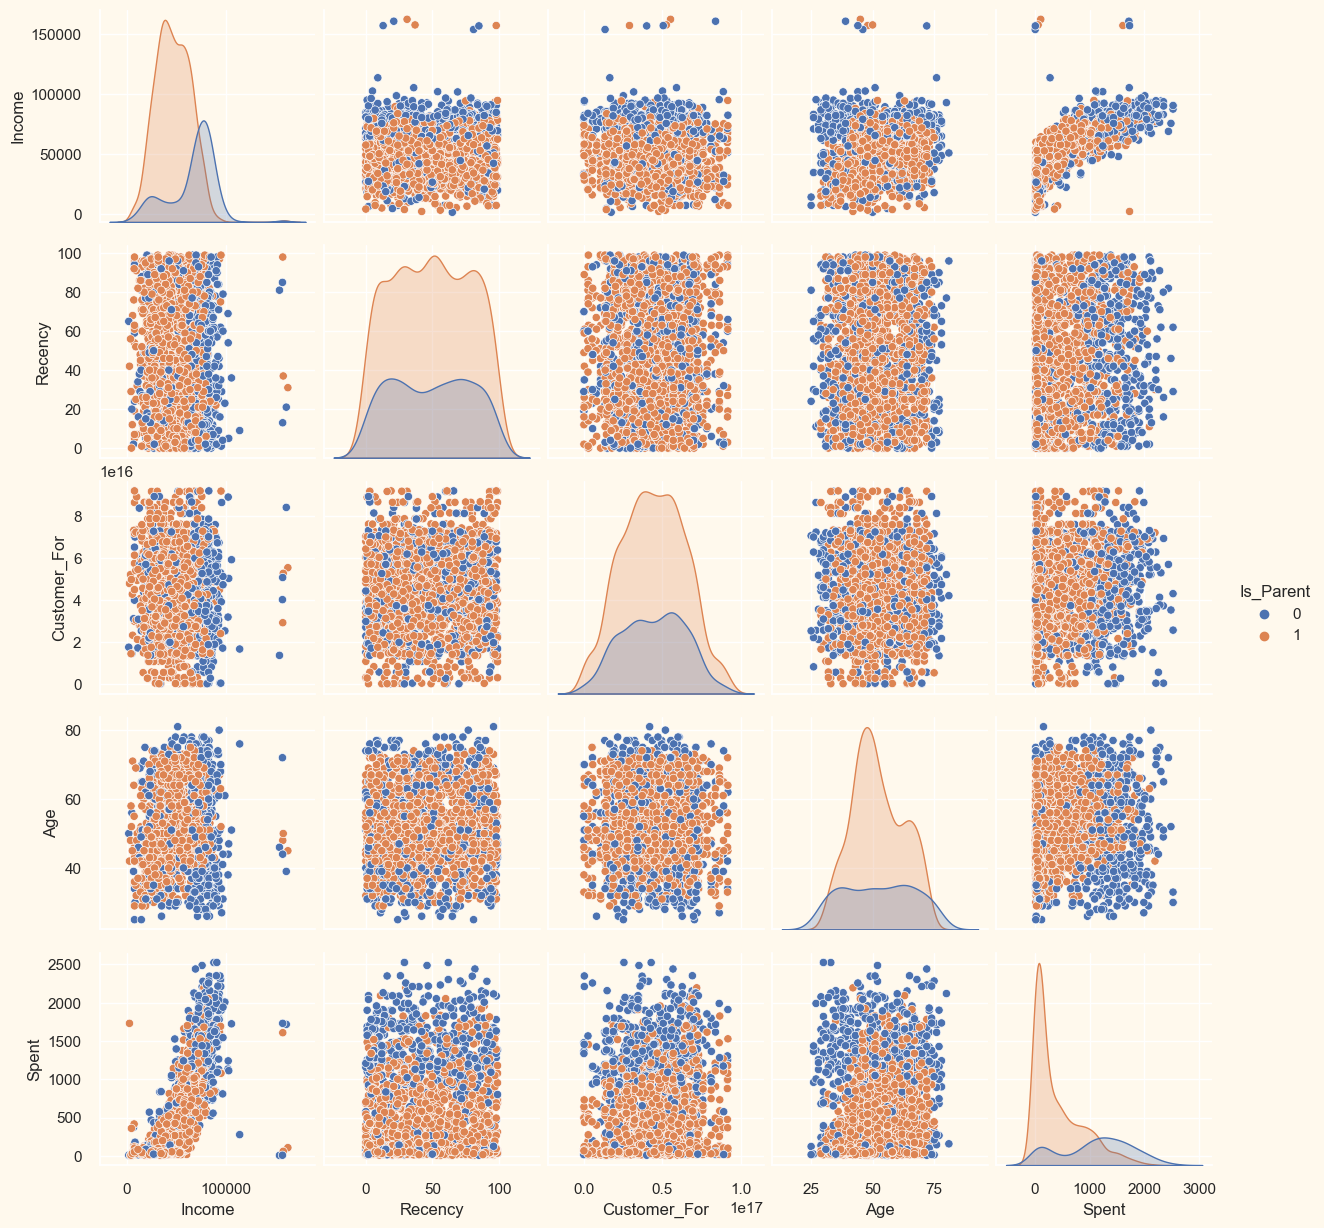

In [112]:
# Let's see the distribution of the categorical variables.
sns.pairplot(df[["Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]], hue= "Is_Parent")
plt.show()

<AxesSubplot:>

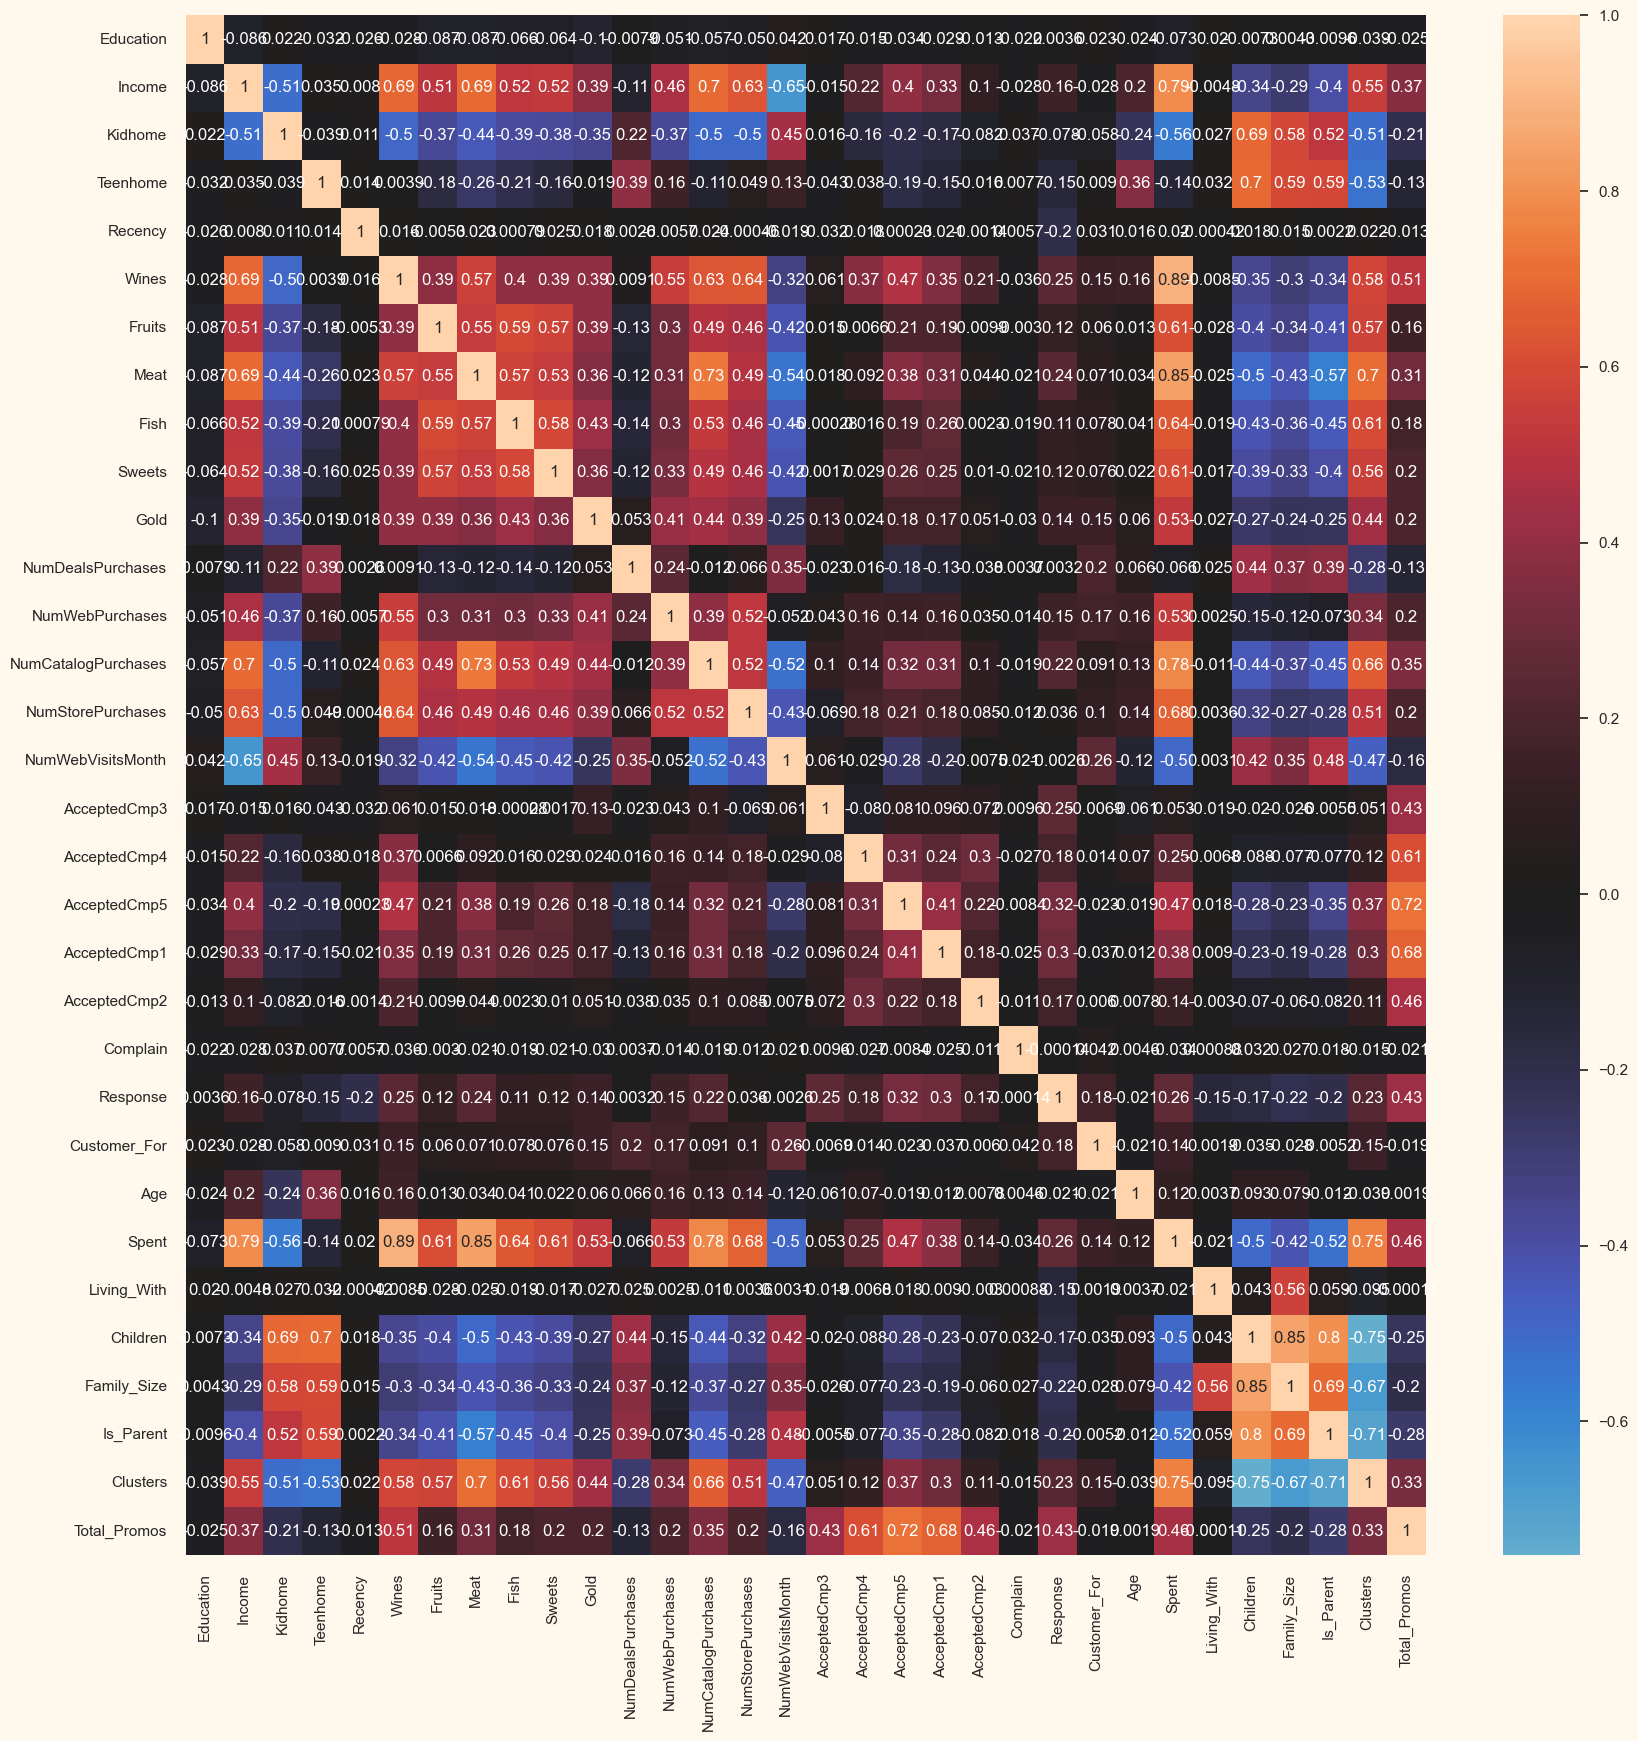

In [113]:
# Let's see the correlation between the variables.
plt.figure(figsize=(20,20))  
sns.heatmap(df.corr(),annot=True, center=0)

## Data Preprocessing

In [114]:
# Creating a copy of the dataframe.
data_copy = df.copy()
# Creating a subset of dataframe and dropping the features that we will not need.
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
data_copy = data_copy.drop(cols_del, axis=1)

# Scaling variables.
scaler = StandardScaler()
scaler.fit(data_copy)
scaled_data = pd.DataFrame(scaler.transform(data_copy),columns= data_copy.columns )
print("All features are now scaled")

# Let's print the first 5 rows of our dataframe.
scaled_data.head()

All features are now scaled


Education    Income   Kidhome  Teenhome   Recency     Wines    Fruits  \
0  -0.893586  0.287105 -0.822754 -0.929699  0.310353  0.977660  1.552041   
1  -0.893586 -0.260882  1.040021  0.908097 -0.380813 -0.872618 -0.637461   
2  -0.893586  0.913196 -0.822754 -0.929699 -0.795514  0.357935  0.570540   
3  -0.893586 -1.176114  1.040021 -0.929699 -0.795514 -0.872618 -0.561961   
4   0.571657  0.294307  1.040021 -0.929699  1.554453 -0.392257  0.419540   

       Meat      Fish    Sweets  ...  NumWebVisitsMonth  Customer_For  \
0  1.690293  2.453472  1.483713  ...           0.692181      1.973583   
1 -0.718230 -0.651004 -0.634019  ...          -0.132545     -1.665144   
2 -0.178542  1.339513 -0.147184  ...          -0.544908     -0.172664   
3 -0.655787 -0.504911 -0.585335  ...           0.279818     -1.923210   
4 -0.218684  0.152508 -0.001133  ...          -0.132545     -0.822130   

        Age     Spent  Living_With  Children  Family_Size  Is_Parent  \
0  1.018352  1.676245    -1.349603 -1.264598    -1.758359  -1.581139   
1  1.274785 -0.963297    -1.349603  1.404572     0.449070   0.632456   
2  0.334530  0.280110     0.740959 -1.264598    -0.654644  -1.581139   
3 -1.289547 -0.920135     0.740959  0.069987     0.449070   0.632456   
4 -1.033114 -0.307562     0.740959  0.069987     0.449070   0.632456   

   Clusters  Total_Promos  
0  1.491095      -0.43916  
1 -1.104631      -0.43916  
2  1.491095      -0.43916  
3 -0.239389      -0.43916  
4 -1.104631      -0.43916  

[5 rows x 25 columns]

# Dimensionality reduction

In this problem, there are many factors on the basis of which the final classification will be done. These factors are basically attributes or features. The higher the number of features, the harder it is to work with it. Many of these features are correlated, and hence redundant. This is why I will be performing dimensionality reduction on the selected features before putting them through a classifier.  
*Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables.* 

**Principal component analysis (PCA)** is a technique for reducing the dimensionality of such dfsets, increasing interpretability but at the same time minimizing information loss.

**Steps in this section:**
* Dimensionality reduction with PCA
* Plotting the reduced dfframe

**Dimensionality reduction with PCA**

For this project, I will be reducing the dimensions to 3.

In [115]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_data)
PCA_df = pd.DataFrame(pca.transform(scaled_data), columns=(["col1","col2", "col3"]))
PCA_df.describe().T

count          mean       std       min       25%       50%       75%  \
col1  2212.0  4.055426e-17  3.030380 -6.056301 -2.543906 -0.999547  2.524679   
col2  2212.0 -3.673975e-17  1.722526 -4.295295 -1.377961 -0.127488  1.267037   
col3  2212.0  3.100544e-17  1.233078 -3.501024 -0.859927 -0.027100  0.836085   

           max  
col1  7.969327  
col2  6.154981  
col3  6.514007

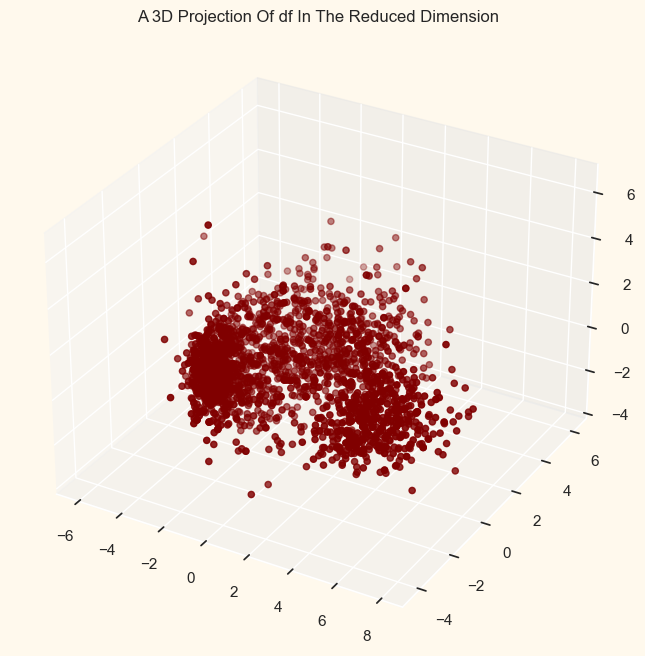

In [116]:
#A 3D Projection Of df In The Reduced Dimension
x =PCA_df["col1"]
y =PCA_df["col2"]
z =PCA_df["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of df In The Reduced Dimension")
plt.show()

# Clustering

Now that I have reduced the attributes to three dimensions, I will be performing clustering via Agglomerative clustering. Agglomerative clustering is a hierarchical clustering method.  It involves merging examples until the desired number of clusters is achieved.

**Steps involved in the Clustering**
* Elbow Method to determine the number of clusters to be formed
* Clustering via Agglomerative Clustering
* Examining the clusters formed via scatter plot

Elbow Method to determine the number of clusters to be formed:


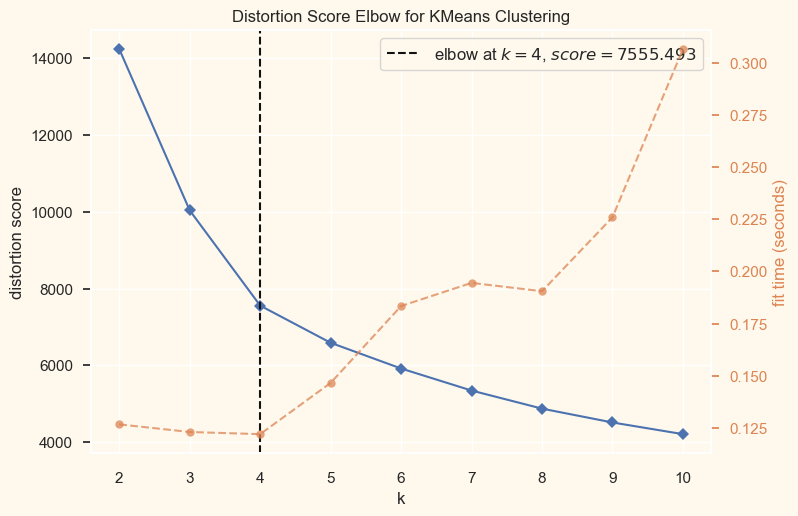

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [117]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_df)
Elbow_M.show()

In [118]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_df)
PCA_df["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dfframe.
df["Clusters"]= yhat_AC

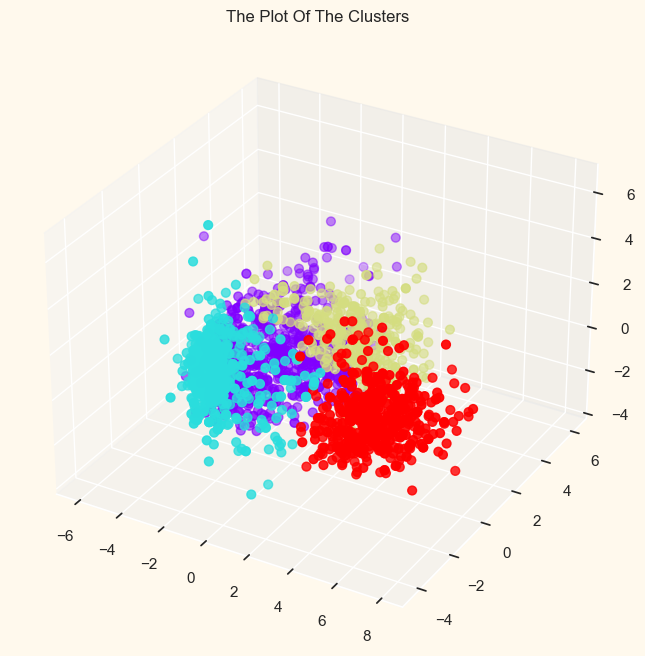

In [119]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_df["Clusters"], marker='o', cmap="rainbow")
ax.set_title("The Plot Of The Clusters")
plt.show()

# Modeling

Since this is an unsupervised clustering. We do not have a tagged feature to evaluate or score our model. The purpose of this section is to study the patterns in the clusters formed and determine the nature of the clusters' patterns. 

For that, we will be having a look at the df in light of clusters via exploratory df analysis and drawing conclusions. 

**Firstly, let us have a look at the group distribution of clustring**

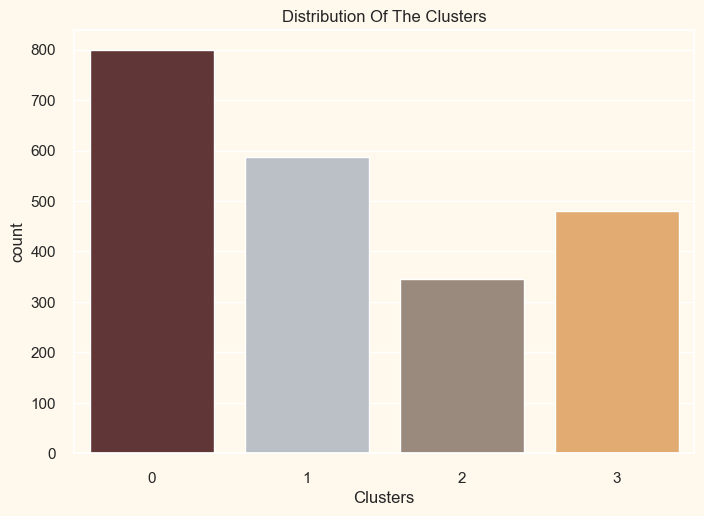

In [120]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=df["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

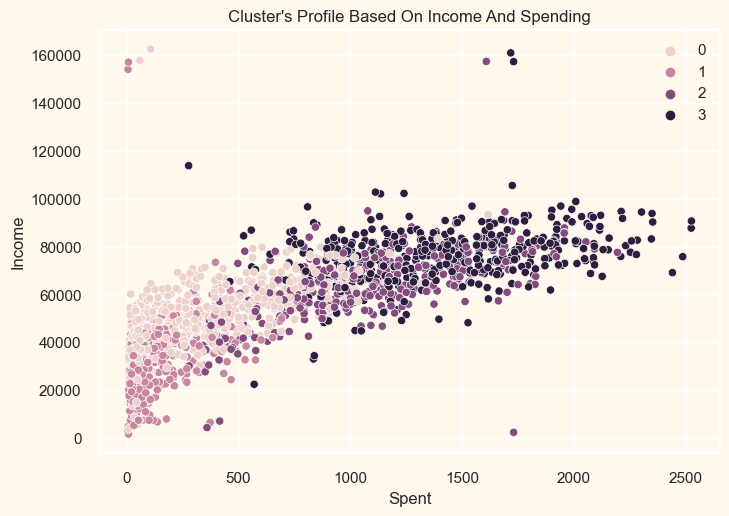

In [121]:
pl = sns.scatterplot(data = df,x=df["Spent"], y=df["Income"],hue=df["Clusters"])
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

**Income vs  spending plot shows the clusters pattern**
* group 0: Low spending & average income
* group 1: Low spending & low income
* group 2: High spending & average income 
* group 3: High spending & high income  

Next, I will be looking at the detailed distribution of clusters as per the various products in the df. Namely: Wines, Fruits, Meat, Fish, Sweets and Gold

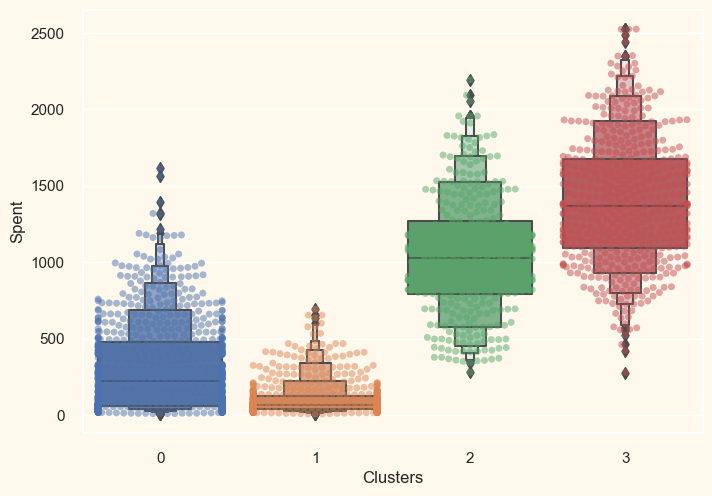

In [122]:
plt.figure()
pl=sns.swarmplot(x=df["Clusters"], y=df["Spent"], alpha=0.5 )
pl=sns.boxenplot(x=df["Clusters"], y=df["Spent"])
plt.show()

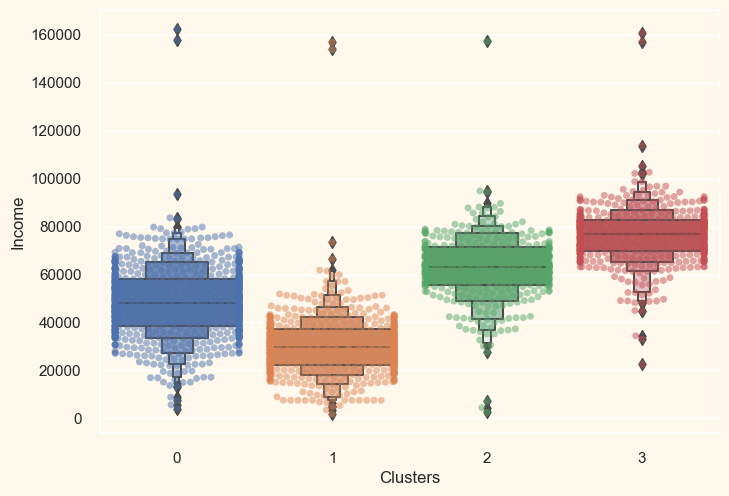

In [127]:
plt.figure()
pl=sns.swarmplot(x=df["Clusters"], y=df["Income"], alpha=0.5 )
pl=sns.boxenplot(x=df["Clusters"], y=df["Income"])
plt.show()


From the above plot, it can be clearly seen that cluster 1 is our biggest set of customers closely followed by cluster 0.
We can explore what each cluster is spending on for the targeted marketing strategies.


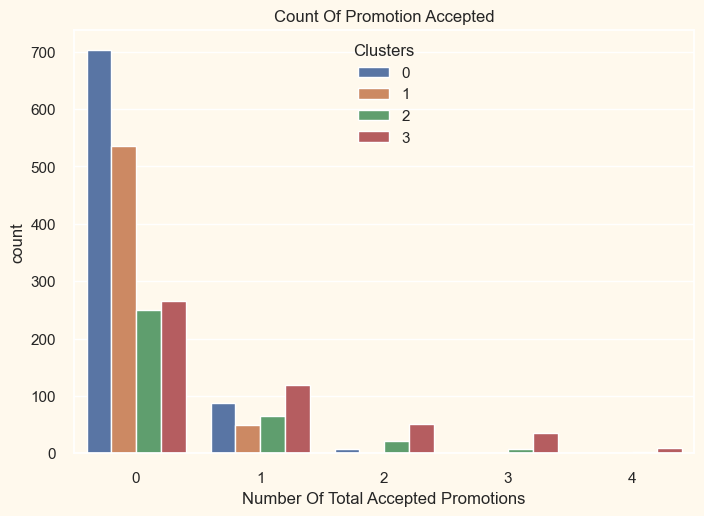

In [123]:
#Creating a feature to get a sum of accepted promotions 
df["Total_Promos"] = df["AcceptedCmp1"]+ df["AcceptedCmp2"]+ df["AcceptedCmp3"]+ df["AcceptedCmp4"]+ df["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=df["Total_Promos"],hue=df["Clusters"])
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

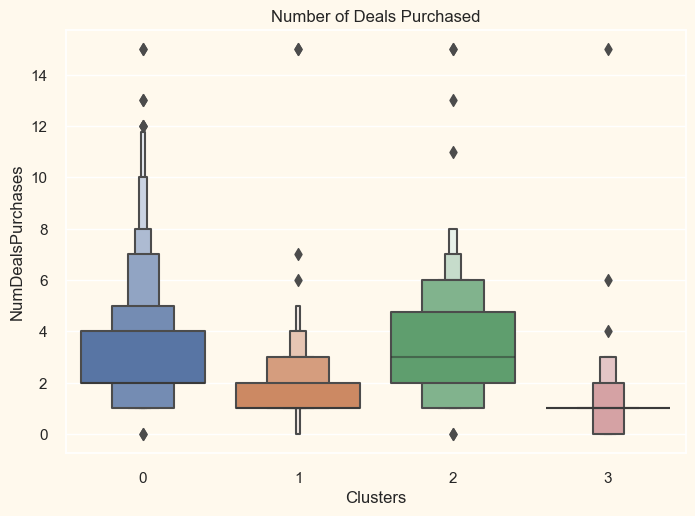

In [124]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=df["NumDealsPurchases"],x=df["Clusters"])
pl.set_title("Number of Deals Purchased")
plt.show()

<Figure size 800x550 with 0 Axes>

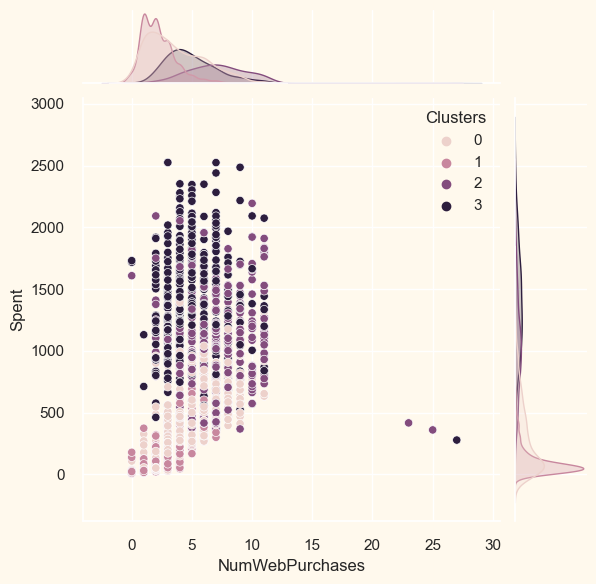

<Figure size 800x550 with 0 Axes>

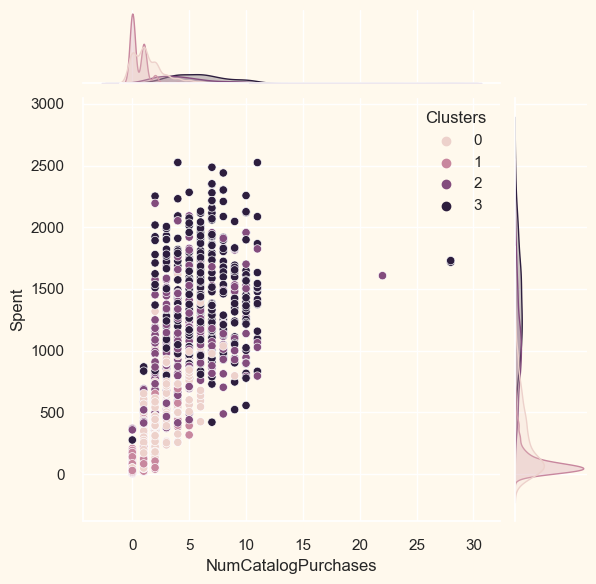

<Figure size 800x550 with 0 Axes>

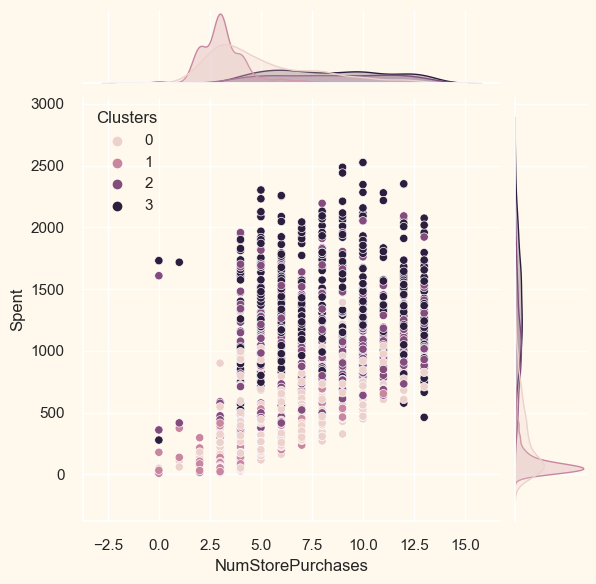

<Figure size 800x550 with 0 Axes>

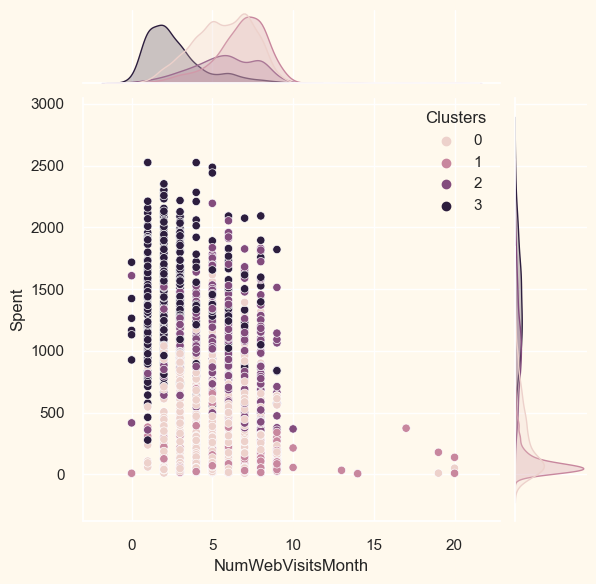

In [125]:
#for more details on the purchasing style 
Places =["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases",  "NumWebVisitsMonth"] 

for i in Places:
    plt.figure()
    sns.jointplot(x=df[i],y = df["Spent"],hue=df["Clusters"])
    plt.show()

# Profiling

Now that we have formed the clusters and looked at their purchasing habits. 
Let us see who all are there in these clusters. For that, we will be profiling the clusters formed and come to a conclusion about who is our star customer and who needs more attention from the retail store's marketing team.

To decide that I will be plotting some of the features that are indicative of the customer's personal traits in light of the cluster they are in. 
On the basis of the outcomes, I will be arriving at the conclusions. 

<Figure size 800x550 with 0 Axes>

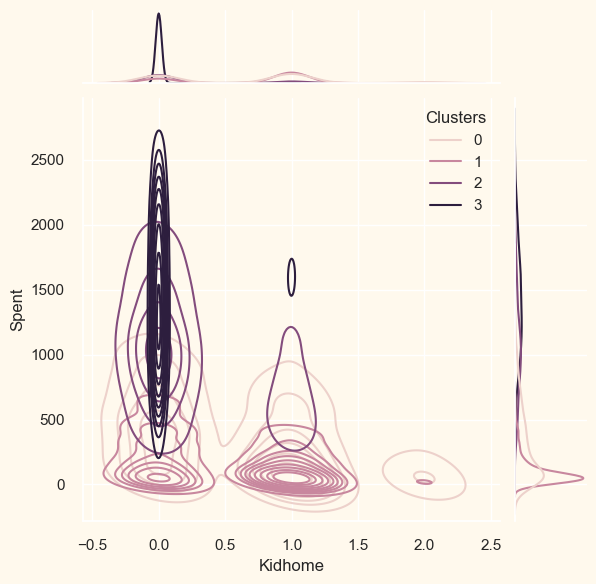

<Figure size 800x550 with 0 Axes>

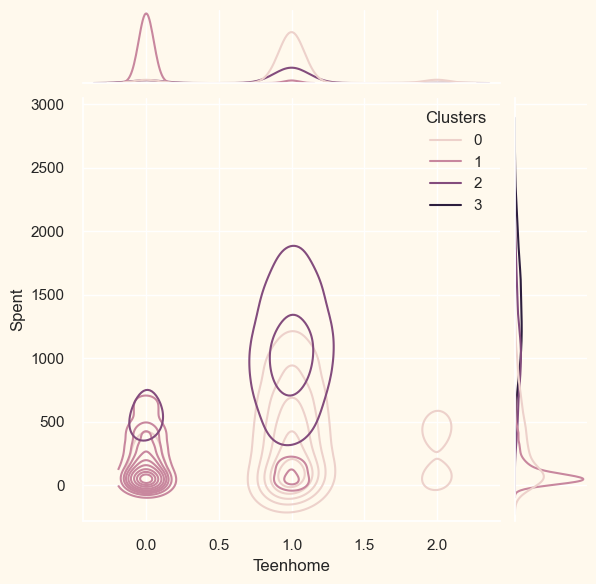

<Figure size 800x550 with 0 Axes>

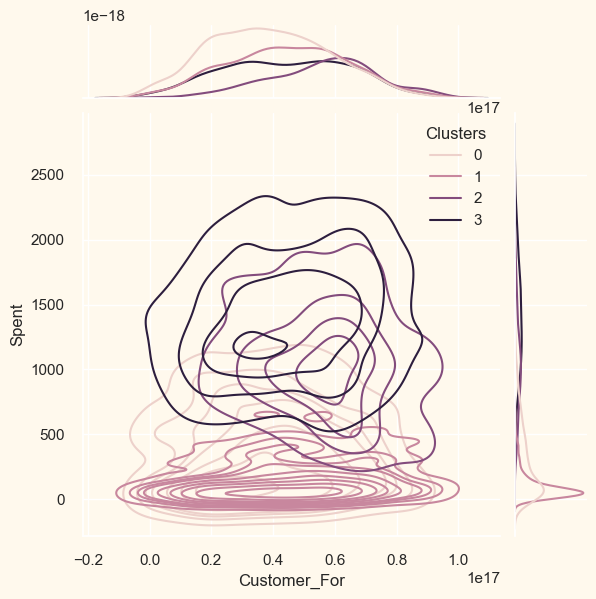

<Figure size 800x550 with 0 Axes>

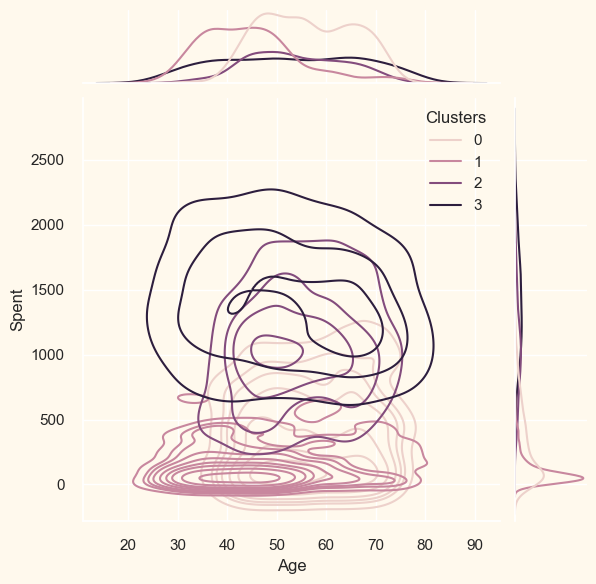

<Figure size 800x550 with 0 Axes>

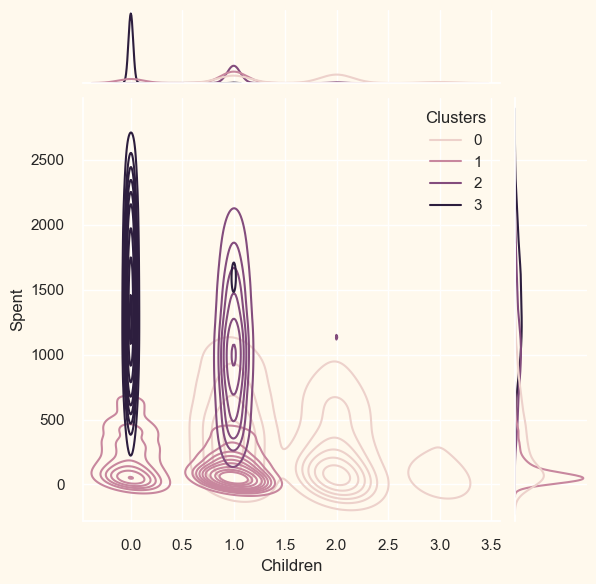

<Figure size 800x550 with 0 Axes>

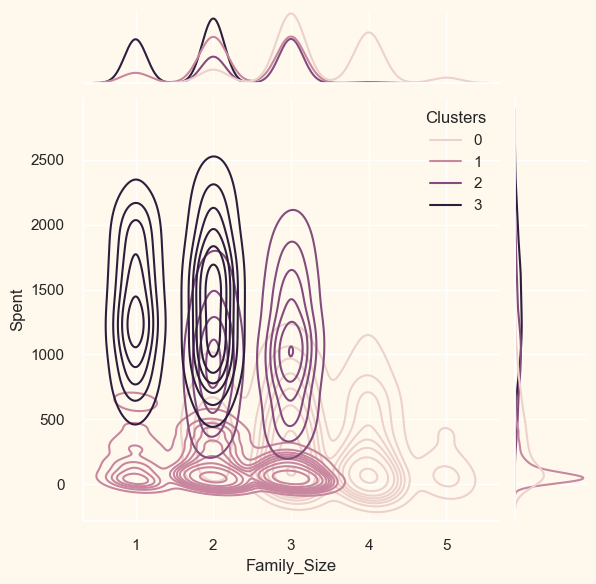

<Figure size 800x550 with 0 Axes>

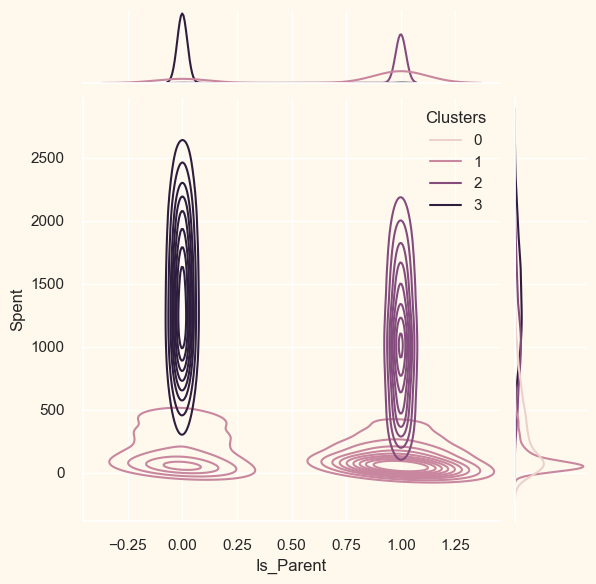

<Figure size 800x550 with 0 Axes>

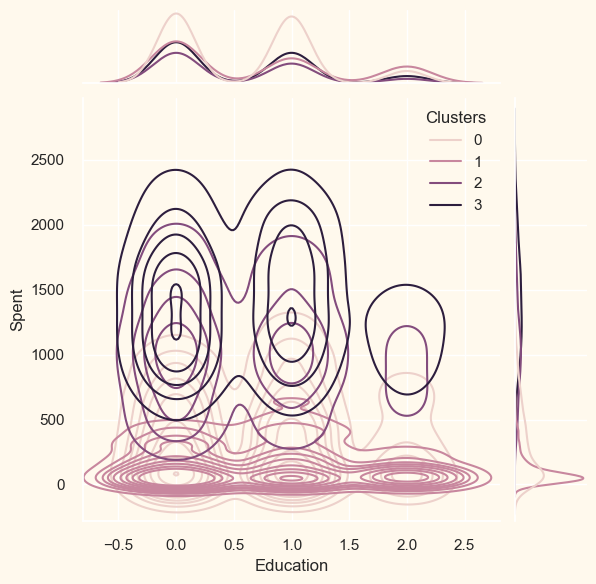

<Figure size 800x550 with 0 Axes>

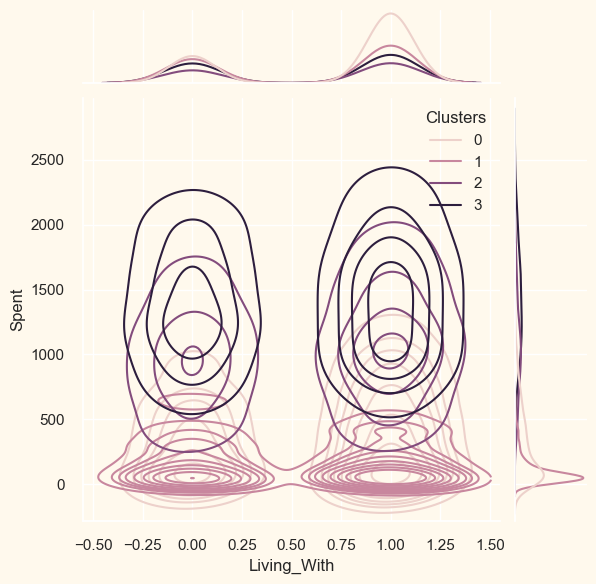

In [126]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=df[i], y=df["Spent"], hue =df["Clusters"], kind="kde")
    plt.show()


# Conclusion

We did unsupervised clustering.
We ended with 4 clusters and further used them in profiling customers in clusters according to their family structures and income/spending. 
This can be used in planning better marketing strategies, according to their profiles and the fit with the product.